In [1]:
!pip install seedtools

In [2]:
import pandas as pd 
from seedtools import mapper_auto
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.preprocessing import KBinsDiscretizer,StandardScaler
from sklearn.ensemble import RandomForestClassifier,VotingClassifier,BaggingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import SVC 
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score


# verbose = 0
import warnings 
warnings.filterwarnings("ignore")

## <center> 1. Data Preprocessing <center/>

In [3]:
data = pd.read_csv("/kaggle/input/spaceship-titanic/train.csv").drop(columns=["PassengerId","Cabin","Name"]).dropna()
df,mappings =  mapper_auto(data,["HomePlanet","VIP","Destination","CryoSleep","Transported"])
cols=  ["FoodCourt","RoomService","ShoppingMall","Spa","VRDeck"] # for future use 

print(mappings)

df.head()

{'HomePlanet': [{'Europa': 0, 'Earth': 1, 'Mars': 2}], 'VIP': [{False: 0, True: 1}], 'Destination': [{'TRAPPIST-1e': 0, 'PSO J318.5-22': 1, '55 Cancri e': 2}], 'CryoSleep': [{False: 0, True: 1}], 'Transported': [{False: 0, True: 1}]}


,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,0,0,0,39.0,0,0.0,0.0,0.0,0.0,0.0,0
1,1,0,0,24.0,0,109.0,9.0,25.0,549.0,44.0,1
2,0,0,0,58.0,1,43.0,3576.0,0.0,6715.0,49.0,0
3,0,0,0,33.0,0,0.0,1283.0,371.0,3329.0,193.0,0
4,1,0,0,16.0,0,303.0,70.0,151.0,565.0,2.0,1


In [4]:
ss = StandardScaler()


# Age Column  =>  bins [0-10,10-20]
kbin = KBinsDiscretizer(n_bins=8,encode="ordinal",strategy="quantile")
df["Age_bin"]  = kbin.fit_transform(data["Age"].values.reshape(-1,1))
df = df.drop(columns=["Age"])

# Just Scale Data 
for col in cols:
    df[col] =  ss.fit_transform(df[col].values.reshape(-1,1))
    
df.head()

,HomePlanet,CryoSleep,Destination,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Age_bin
0,0,0,0,0,-0.335500,-0.287229,-0.283044,-0.274495,-0.269928,0,6.0
1,1,0,0,0,-0.173745,-0.281849,-0.243585,0.199122,-0.230830,1,3.0
2,0,0,0,1,-0.271688,1.850701,-0.283044,5.518474,-0.226387,0,7.0
3,0,0,0,0,-0.335500,0.479819,0.302527,2.597403,-0.098429,0,5.0
4,1,0,0,0,0.114149,-0.245379,-0.044712,0.212925,-0.268151,1,1.0


**CryoSleep** has very high correlation ~46% <br />
=>  where a person (or other lifeform) is put into a state of deep, preserved unconsciousness by cooling their body to extremely low temperatures.

I Tried adding all the cols like : `df["TotalBill"] = ["FoodCourt","RoomService","ShoppingMall","Spa","VRDeck"]` still have negative corr

## <center> 2. EDA and Analysis <center/>

In [5]:
df.corr()["Transported"]

HomePlanet     -0.109052
CryoSleep       0.462165
Destination     0.119065
VIP            -0.041231
RoomService    -0.242456
FoodCourt       0.051395
ShoppingMall    0.012922
Spa            -0.220362
VRDeck         -0.207137
Transported     1.000000
Age_bin        -0.077485
Name: Transported, dtype: float64

<Axes: xlabel='CryoSleep', ylabel='Transported'>

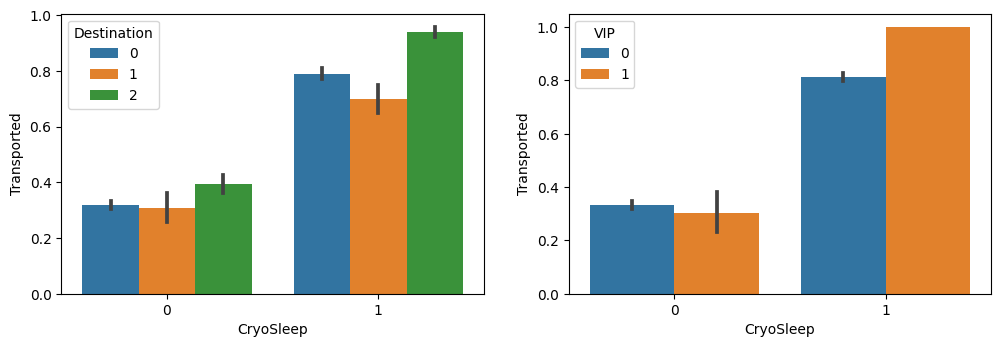

In [6]:
plt.figure(figsize=(12, 8))
plt.subplot(2,2,1)
sns.barplot(df,x="CryoSleep",y="Transported",hue="Destination")

plt.subplot(2,2,2)
sns.barplot(df,x="CryoSleep",y="Transported",hue="VIP")

<Axes: xlabel='Age_bin', ylabel='count'>

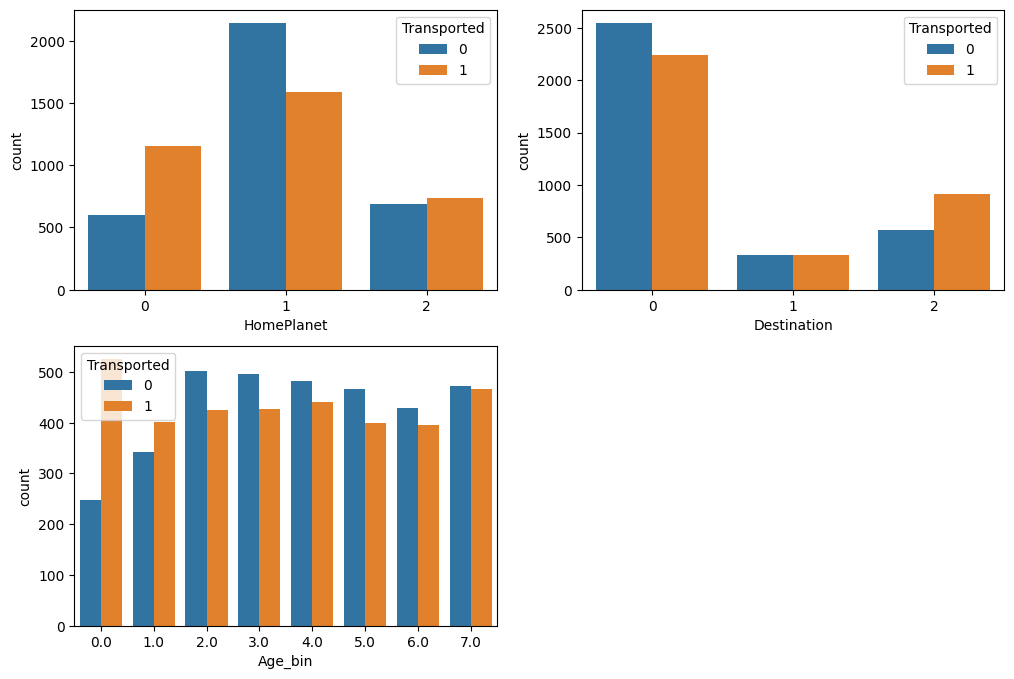

In [7]:
plt.figure(figsize=(12, 8))
plt.subplot(2,2,1)
sns.countplot(df,x="HomePlanet",hue="Transported")


plt.subplot(2,2,2)
sns.countplot(df,x="Destination",hue="Transported")

plt.subplot(2,2,3)
sns.countplot(df,x="Age_bin",hue="Transported")



HomePlanet   `Europa` and    `Mars` has more chance of transportationHomePlanet    <br />
Destination `55 Cancri e` has more chance of transportation

Age skewness : 0.41075188970350823


<Axes: xlabel='Age', ylabel='Density'>

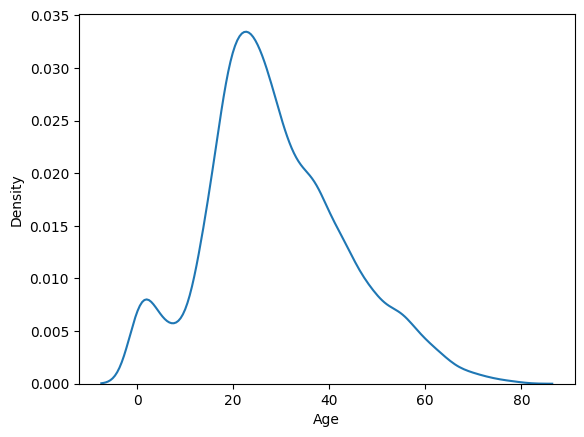

In [8]:

print("Age skewness :",data.Age.skew())
sns.kdeplot(data.Age)

In [9]:
x =  df.drop(columns=["Transported"]).values
y =  df["Transported"].values
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.14)
x_train.shape

(5953, 10)

## <center> 3. Model Building <center/>

In [10]:
def score_model(model):
    if "model_" in (locals() or globals()):
        del model_
        
    print(f"{model.__name__} :")
    model_ =  model()
    model_.fit(x_train,y_train)
    score =model_.score(x_test,y_test)
    pred =  model_.predict(x_test)
    
    r2  = r2_score(y_test,pred)
    
    print(f"|| Score : {score}")
    print(f"|| R2 Score : {r2}")
    

### Voting Classifier 

In [11]:
clf1 = LogisticRegression()
clf2 = RandomForestClassifier()
clf3 = SVC()
voting = VotingClassifier(estimators=[
        ('lr', clf1), ('rf', clf2), ('gnb', clf3)])

voting.fit(x_train,y_train)
score =voting.score(x_test,y_test)
pred =  voting.predict(x_test)              
r2  = r2_score(y_test,pred) 
print("Voting Classifer :")              
print(f"|| Score : {score}")
print(f"|| R2 Score : {r2}")

Voting Classifer :
|| Score : 0.7793814432989691
|| R2 Score : 0.11413634908780546


### BaggingClassifer

In [12]:
base_model =  RandomForestClassifier()
bagg =  BaggingClassifier(estimator=base_model)
bagg.fit(x_train,y_train)
score =bagg.score(x_test,y_test)
pred =  bagg.predict(x_test)              
r2  = r2_score(y_test,pred) 
print(f"Bagging  Classifer ({type(base_model).__name__}): ")              
print(f"|| Score : {score}")
print(f"|| R2 Score : {r2}")

Bagging  Classifer (RandomForestClassifier): 
|| Score : 0.7752577319587629
|| R2 Score : 0.09757815000533454


### Multiple Models

In [13]:
score_model(RandomForestClassifier)
score_model(LogisticRegression)
score_model(GaussianNB)
score_model(XGBClassifier)
score_model(SVC)

RandomForestClassifier :
|| Score : 0.7731958762886598
|| R2 Score : 0.08929905046409914
LogisticRegression :
|| Score : 0.7639175257731958
|| R2 Score : 0.0520431025285395
GaussianNB :
|| Score : 0.7010309278350515
|| R2 Score : -0.20046943347914215
XGBClassifier :
|| Score : 0.7783505154639175
|| R2 Score : 0.10999679931718775
SVC :
|| Score : 0.7742268041237114
|| R2 Score : 0.09343860023471684


**FINAL MODEL :  Voting Classifer**

## <center> 4. Making Predictions <center/> 

In [14]:
test_data = pd.read_csv("/kaggle/input/spaceship-titanic/test.csv").drop(columns=["Cabin","Name"]).fillna(0)
df_test,mappings =  mapper_auto(test_data,["HomePlanet","VIP","Destination","CryoSleep","Transported"])

df_test["Age_bin"]  = kbin.transform(df_test["Age"].values.reshape(-1,1))
df_test = df_test.drop(columns=["Age"])

# Just Scale Data 
for col in cols:
    df_test[col] =  ss.fit_transform(df_test[col].values.reshape(-1,1))

df_test.head()

,PassengerId,HomePlanet,CryoSleep,Destination,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Age_bin
0,0013_01,0,0,0,0,-0.357339,-0.283840,-0.312173,-0.267841,-0.246712,4.0
1,0018_01,0,1,0,0,-0.357339,-0.277879,-0.312173,2.287504,-0.246712,2.0
2,0019_01,1,0,1,0,-0.357339,-0.283840,-0.312173,-0.267841,-0.246712,4.0
3,0021_01,1,1,0,0,-0.357339,4.121518,-0.312173,-0.104002,0.226648,6.0
4,0023_01,0,1,0,0,-0.340723,-0.283840,0.832122,-0.267841,-0.246712,2.0


In [15]:
test_X =  test_data.drop(columns=["PassengerId","Age"])

preds =  voting.predict(test_X)
preds

array([0, 0, 0, ..., 0, 1, 0])

## <center>  5. Submission <center/>

In [16]:
predictions =  pd.DataFrame({"PassengerId":test_data["PassengerId"].values,"Transported":preds})
predictions["Transported"] =  predictions["Transported"].map({0:False,1:True})
predictions.head()

,PassengerId,Transported
0,0013_01,False
1,0018_01,False
2,0019_01,False
3,0021_01,False
4,0023_01,True


In [17]:
predictions.to_csv("spaceship_submission.csv",index=False)